In [17]:
import numpy as np


#########################
# Temporary data import #
#########################

from DAQRead import *
raw = DAQReader('spectrum_for_1p3eV.raw')
raw.read_pulses()
shape_data = raw.data['data'].shape
traces = np.reshape(raw.data['data'], (shape_data[0], 1, shape_data[1]))
channels = np.reshape(np.tile([1, -1], shape_data[0]), (shape_data[0], 2))
indeces = np.reshape(np.repeat(np.arange(shape_data[0]), 2), (shape_data[0],2))

traces = traces.reshape(8654, 32768)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def filter_and_group_traces(traces):
    # Step 1: Compute mean of each trace
    trace_means = np.mean(traces, axis=1)
    
    # Step 2: Filter traces with mean in (4700, 5600)
    mask_mean = (trace_means > 4700) & (trace_means < 5600)
    filtered_traces = traces[mask_mean]
    filtered_means = trace_means[mask_mean]
    
    # Step 3: Compute the baseline (mean of first 2048 samples) for each filtered trace
    baselines = np.mean(filtered_traces[:, :2048], axis=1)
    
    # Step 4: Keep traces where baseline is between 129 and 133
    mask_baseline = (baselines > 129) & (baselines < 133)
    final_traces = filtered_traces[mask_baseline]
    final_means = filtered_means[mask_baseline]
    final_baselines = baselines[mask_baseline]
    
    # Step 5: Compute height (Max - Min) for remaining traces
    heights = np.max(final_traces, axis=1) - np.min(final_traces, axis=1)
    
    # Step 6: Separate traces into two groups based on height
    group1_mask = (heights > 10400) & (heights < 10600)
    group2_mask = (heights > 11400) & (heights < 11600)
    
    group1_traces = final_traces[group1_mask]
    group2_traces = final_traces[group2_mask]
    group1_heights = heights[group1_mask]
    group2_heights = heights[group2_mask]
    
    # Identify bad traces as all traces except those in group1 and group2
    good_mask = group1_mask | group2_mask
    bad_traces = final_traces[~good_mask]
    
    # Compute mean values for each trace in group 1 and group 2
    group1_means = np.mean(group1_traces, axis=1)
    group2_means = np.mean(group2_traces, axis=1)
    
    # Plot histograms of the mean values for group 1 and group 2
    plt.figure(figsize=(10, 5))
    plt.hist(group1_means, bins=30, alpha=0.7, label='Ka traces')
    plt.hist(group2_means, bins=30, alpha=0.7, label='Kb traces')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram of Mean Values for Ka and Kb traces')
    plt.show()
    
    print(f"Total traces: {traces.shape[0]}")
    print(f"Filtered by mean (4700, 5600): {filtered_traces.shape[0]}")
    print(f"Filtered by baseline (129, 133): {final_traces.shape[0]}")
    print(f"Group 1 (Height 10400-10600): {group1_traces.shape[0]}")
    print(f"Group 2 (Height 11400-11600): {group2_traces.shape[0]}")
    print(f"Bad traces (failed filtering): {bad_traces.shape[0]}")
    
    return group1_traces, group2_traces, group1_heights, group2_heights, bad_traces


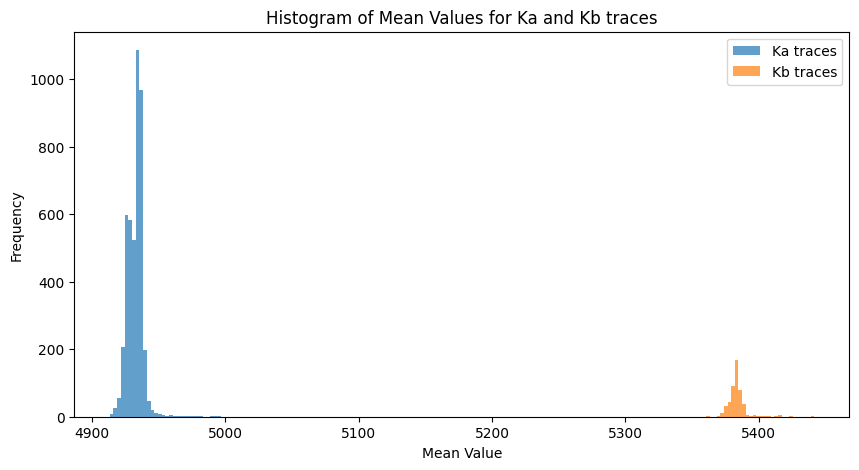

Total traces: 8654
Filtered by mean (4700, 5600): 8284
Filtered by baseline (129, 133): 5086
Group 1 (Height 10400-10600): 4364
Group 2 (Height 11400-11600): 499
Bad traces (failed filtering): 223


In [8]:
gp1, gp2, gp1h, gp2h, btraces = filter_and_group_traces(traces)

In [14]:
gp1_half1 = gp1[:gp1.shape[0] // 2]  # First half
gp1_half2 = gp1[gp1.shape[0] // 2:]  # Second half

# Save the split data
np.savez_compressed("Ka_traces_1.npz", data=gp1_half1)
np.savez_compressed("Ka_traces_2.npz", data=gp1_half2)

# Save Kb traces as is
np.savez_compressed("Kb_traces.npz", data=gp2)

print("Ka traces split and saved successfully.")
print("Kb traces saved successfully.")

Ka traces split and saved successfully.
Kb traces saved successfully.


In [30]:
btraces.shape

(223, 32768)

In [11]:
# To load it back:
loaded = np.load("Ka_traces.npz")
data = loaded["data"]

print("Compressed NumPy file saved and loaded successfully!")

Compressed NumPy file saved and loaded successfully!


In [12]:
data.shape

(4364, 32768)

In [17]:
import numpy as np
import pandas as pd

# Load the saved compressed npz files
ka_traces_1 = np.load("Ka_traces_1.npz")['data']
kb_traces = np.load("Kb_traces.npz")['data']

# Extract the first 100 traces
ka_template_traces = ka_traces_1[:100]
kb_template_traces = kb_traces[:100]

# Convert to DataFrame
ka_df = pd.DataFrame(ka_template_traces)
kb_df = pd.DataFrame(kb_template_traces)

# Save as CSV
ka_df.to_csv("Ka_template_traces.csv", index=False)
kb_df.to_csv("Kb_template_traces.csv", index=False)

print("Ka and Kb template traces extracted and saved as CSV successfully.")


Ka and Kb template traces extracted and saved as CSV successfully.


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def filter_and_group_traces(traces):
    trace_means = np.mean(traces, axis=1)

    mask_mean = (trace_means > 4700) & (trace_means < 5600)
    filtered_traces = traces[mask_mean]

    heights_before = np.max(filtered_traces, axis=1) - np.min(filtered_traces, axis=1)

    baselines = np.mean(filtered_traces[:, :2048], axis=1)
    mask_baseline = (baselines > 129) & (baselines < 133)
    traces_after_baseline = filtered_traces[mask_baseline]

    heights_after = np.max(traces_after_baseline, axis=1) - np.min(traces_after_baseline, axis=1)

    group1_mask_before = (heights_before > 10400) & (heights_before < 10600)
    group2_mask_before = (heights_before > 11400) & (heights_before < 11600)

    group1_mask_after = (heights_after > 10400) & (heights_after < 10600)
    group2_mask_after = (heights_after > 11400) & (heights_after < 11600)

    plt.figure(figsize=(10, 5))
    plt.hist(heights_before[group1_mask_before], bins=100, alpha=0.7, histtype='step', linewidth=1.5, color='orange')
    plt.hist(heights_after[group1_mask_after], bins=100, alpha=0.7, color='blue')
    plt.xlabel("Trace Heights")
    plt.ylabel("Frequency")
    plt.title("Ka height spectrum")
    plt.grid(True)
    plt.legend(['Before baseline cut', 'After baseline cut'])
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(heights_before[group2_mask_before], bins=100, alpha=0.7, histtype='step', linewidth=1.5, color='orange')
    plt.hist(heights_after[group2_mask_after], bins=100, alpha=0.7, color='blue')
    plt.xlabel("Trace Heights")
    plt.ylabel("Frequency")
    plt.title("Kb height spectrum")
    plt.grid(True)
    plt.legend(['Before baseline cut', 'After baseline cut'])
    plt.show()

    print(f"Total traces: {traces.shape[0]}")
    print(f"Filtered by mean (4700, 5600): {filtered_traces.shape[0]}")
    print(f"Filtered by baseline (129, 133): {traces_after_baseline.shape[0]}")
    print(f"Group 1 before baseline filtering: {group1_mask_before.sum()}")
    print(f"Group 1 after baseline filtering: {group1_mask_after.sum()}")
    print(f"Group 2 before baseline filtering: {group2_mask_before.sum()}")
    print(f"Group 2 after baseline filtering: {group2_mask_after.sum()}")

    return traces_after_baseline[group1_mask_after], traces_after_baseline[group2_mask_after]

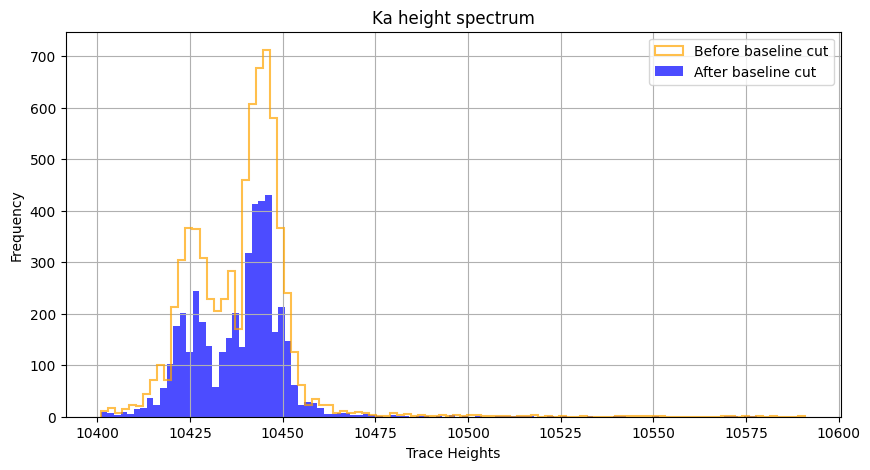

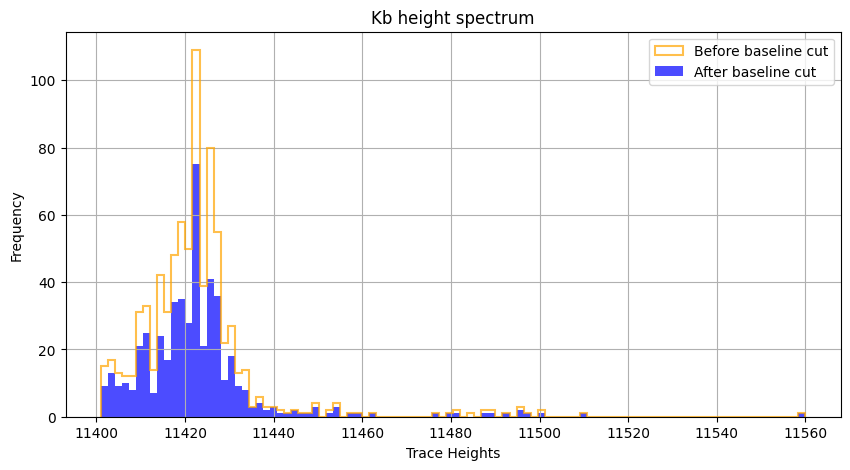

Total traces: 8654
Filtered by mean (4700, 5600): 8284
Filtered by baseline (129, 133): 5086
Group 1 before baseline filtering: 7110
Group 1 after baseline filtering: 4364
Group 2 before baseline filtering: 788
Group 2 after baseline filtering: 499


(array([[ 122,  121,  123, ..., 2540, 2547, 2555],
        [ 130,  130,  132, ..., 2549, 2551, 2553],
        [ 124,  132,  137, ..., 2582, 2570, 2574],
        ...,
        [ 131,  128,  124, ..., 2556, 2551, 2556],
        [ 133,  137,  132, ..., 2562, 2558, 2560],
        [ 130,  122,  127, ..., 2548, 2548, 2550]]),
 array([[ 129,  131,  130, ..., 2784, 2786, 2787],
        [ 142,  134,  128, ..., 2791, 2787, 2784],
        [ 139,  138,  132, ..., 2788, 2786, 2777],
        ...,
        [ 124,  126,  129, ..., 2769, 2775, 2774],
        [ 128,  126,  128, ..., 2788, 2781, 2783],
        [ 118,  120,  118, ..., 2779, 2785, 2777]]))

In [19]:
filter_and_group_traces(traces)

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(gp1h, bins=100, edgecolor='black', alpha=0.7)  # Adjust bins if needed
plt.xlabel("Mean Value of Each Trace")
plt.ylabel("Frequency")
plt.title("Histogram of Trace Means")
plt.grid(True)

NameError: name 'gp1h' is not defined

<Figure size 1000x500 with 0 Axes>

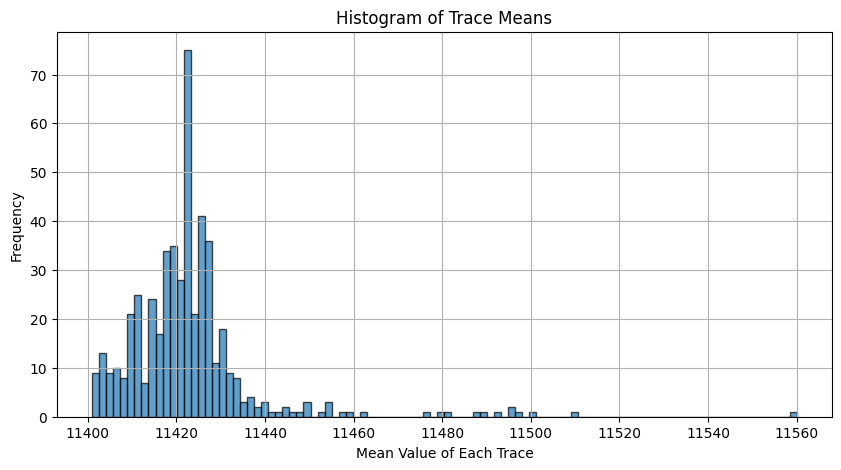

In [26]:
height_trace = np.max(traces, axis=1) - np.min(traces, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(gp2h, bins=100, alpha=0.7)  # Adjust bins if needed
plt.xlabel("Mean Value of Each Trace")
plt.ylabel("Frequency")
plt.title("Histogram of Trace Means")
plt.grid(True)

In [1]:
8284/8654

0.9572452045296973

In [2]:
5086/8284


0.6139546112988894